# S&P 500

## Import Libraries

In [1]:
import pandas as pd
import os
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import scipy.stats as stats

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# gathering data, only done once for EDA
"""df = pd.read_csv("archive/sp500_stocks.csv")
sp = df["Symbol"].unique()
sp.sort()
sp = list(sp)"""

'df = pd.read_csv("archive/sp500_stocks.csv")\nsp = df["Symbol"].unique()\nsp.sort()\nsp = list(sp)'

In [3]:
# gathering data, only done once for EDA
"""data = os.listdir("data")
data.sort()
data = list(data)"""

'data = os.listdir("data")\ndata.sort()\ndata = list(data)'

In [4]:
# create master dataframe from single dfs
"""
df = pd.DataFrame()
for i in data:
    if i.replace(".csv", "") in sp:
        df2 = pd.read_csv(f"data/{i}")
        df2["company"] = i.replace(".csv", "")
        df = pd.concat([df, df2], ignore_index=True)
"""

'\ndf = pd.DataFrame()\nfor i in data:\n    if i.replace(".csv", "") in sp:\n        df2 = pd.read_csv(f"data/{i}")\n        df2["company"] = i.replace(".csv", "")\n        df = pd.concat([df, df2], ignore_index=True)\n'

In [5]:
#df.to_csv("master1.csv")

In [6]:
df = pd.read_csv("master1.csv")

## Cleaning

In [7]:
# cleaning

df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True) # set date as index
df.drop(columns="unnamed:_0", inplace=True) # drop unnamed column

## Basic Exploration

In [8]:
df.shape

(4237175, 8)

In [9]:
# number of companies
len(df["company"].unique())

500

In [10]:
df.head(3)

,open,high,low,close,volume,dividends,stock_splits,company
date,,,,,,,,
1999-11-18 00:00:00-05:00,27.466222,30.182664,24.146130,26.560743,62546380,0.0,0.0,A
1999-11-19 00:00:00-05:00,25.919359,25.957089,24.032944,24.372499,15234146,0.0,0.0,A
1999-11-22 00:00:00-05:00,24.938424,26.560743,24.183858,26.560743,6577870,0.0,0.0,A


Text(0, 0.5, 'Price')

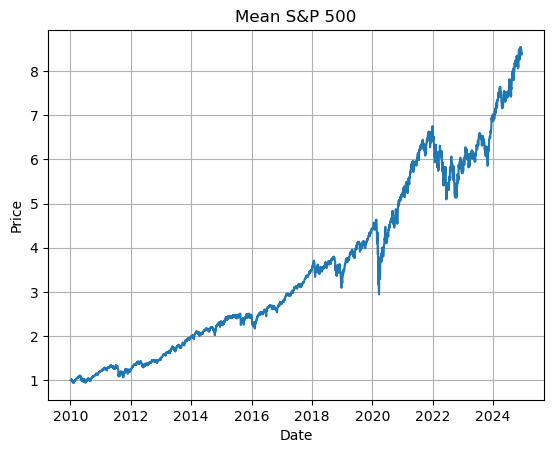

In [11]:
# plotting mean S&P 500 value since 2010

mean = df.groupby("date")["close"].mean().reset_index()

mean_2010 = mean.copy()
mean_2010["date"] = pd.to_datetime(mean_2010["date"], utc=True)
mean_2010 = mean_2010.set_index("date")
mean_2010 = mean_2010.loc["2010":]

start = mean_2010.iloc[0] # starting value for normalizing
mean_2010 = mean_2010/start # normalizing values

sns.lineplot(data=mean_2010, x="date", y="close")

plt.grid(True)
plt.title('Mean S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')

## Feature Engineering

In [12]:
# normalize price, starting 2010
df_2010 = df.copy().sort_index()
df_2010 = df_2010.reset_index()
df_2010["date"] = pd.to_datetime(df_2010["date"], utc=True)
df_2010 = df_2010.set_index("date")
df_2010 = df_2010.loc["2010":]

df_2010["norm_price_2010"] = df_2010.groupby("company")["close"].transform(lambda x: x / x.iloc[0])

In [13]:
# add sector information from webscraping
sector_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/sector_df.csv')
df_2010 = df_2010.reset_index()
df_2010_sector = df_2010.merge(sector_df, on="company", how="left")
df_2010_sector = df_2010_sector.drop(columns="Unnamed: 0")

In [14]:
# strip time
df_2010_sector["date"] = pd.to_datetime(df_2010_sector["date"]).dt.date

In [15]:
# add marketcap data from webscraping
caps_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/caps_df.csv')
df_2010_sector_caps = df_2010_sector.merge(caps_df, on="company", how="left")
df_2010_sector_caps = df_2010_sector_caps.drop(columns="Unnamed: 0")

In [16]:
df_2010_sector_caps["marketcap"] = df_2010_sector_caps["marketcap"].map(lambda x: x.replace("B", "").replace(",", ""))
df_2010_sector_caps["marketcap"] = df_2010_sector_caps["marketcap"].map(lambda x: pd.to_numeric(x))

In [17]:
df_2010_sector_caps["subsector"].nunique()

126

In [18]:
df.head(3)

,open,high,low,close,volume,dividends,stock_splits,company
date,,,,,,,,
1999-11-18 00:00:00-05:00,27.466222,30.182664,24.146130,26.560743,62546380,0.0,0.0,A
1999-11-19 00:00:00-05:00,25.919359,25.957089,24.032944,24.372499,15234146,0.0,0.0,A
1999-11-22 00:00:00-05:00,24.938424,26.560743,24.183858,26.560743,6577870,0.0,0.0,A


In [19]:
df_2010_sector_caps.head(10)

,date,open,high,low,close,volume,dividends,stock_splits,company,norm_price_2010,sector,subsector,marketcap
0,2010-01-04,21.709659,22.024096,21.598086,21.746851,2347600,0.0,0.0,ETN,1.0,industrials,Electrical Components & Equipment,147.70
1,2010-01-04,25.098662,25.564853,24.966366,25.319157,6433800,0.0,0.0,BBY,1.0,consumer discretionary,Computer & Electronics Retail,19.34
2,2010-01-04,21.191422,21.513848,21.070512,21.465483,2455900,0.0,0.0,COR,1.0,health care,Health Care Distributors,47.53
3,2010-01-04,35.644225,36.768141,35.644225,36.334629,3118200,0.0,0.0,WDC,1.0,information technology,"Technology Hardware, Storage & Peripherals",25.22
4,2010-01-04,25.427227,25.603756,25.250699,25.575514,1048000,0.0,0.0,HSY,1.0,consumer staples,Packaged Foods & Meats,35.40
5,2010-01-04,12.603120,12.718305,12.459139,12.526330,904961,0.0,0.0,O,1.0,real estate,Retail REITs,49.22
6,2010-01-04,21.588588,21.695251,21.396594,21.624142,2631000,0.0,0.0,ALL,1.0,financials,Property & Casualty Insurance,54.44
7,2010-01-04,21.246631,21.489604,21.145392,21.239882,3472500,0.0,0.0,ADM,1.0,consumer staples,Agricultural Products & Services,25.03
8,2010-01-04,19.639420,19.710622,19.432761,19.601213,3637000,0.0,0.0,ICE,1.0,financials,Financial Exchanges & Data,89.97
9,2010-01-04,12.029400,12.404018,12.004426,12.337420,4911500,0.0,0.0,SWKS,1.0,information technology,Semiconductors,13.84


In [20]:
#df_2010_sector_caps.to_csv("master2.csv")

In [21]:
#df_2010_sector.to_csv("df_2010_sector.csv")

In [22]:
#df_2010.to_csv("df_2010.csv")

## More feature engineering

In [23]:
# create df for EDA consisting of company data, volume since 2010
master2 = df_2010_sector_caps.copy()

In [24]:
# create df with top 20 companies
eda_df = master2[["company", "marketcap"]]
eda_df.drop_duplicates(inplace=True)
eda_df = eda_df.sort_values(by="marketcap", ascending=False)
eda_df = eda_df.head(20).reset_index()

In [25]:
# merge df with sector information
volume_company = master2.groupby("company")["volume"].sum().reset_index()
sectors = master2[["company", "sector", "subsector"]]
eda_df = eda_df.merge(volume_company, how="inner", on="company")
eda_df = eda_df.merge(sectors, how="inner", on="company")
eda_df.drop_duplicates(inplace=True)
eda_df = eda_df.drop(columns="index").reset_index().drop(columns="index")

In [26]:
top_20_comp = list(eda_df["company"])

In [27]:
# dataset starting 2020
master_2020 = master2.copy()
master_2020["date"] = pd.to_datetime(master_2020["date"])
master_2020 = master_2020.set_index("date")
master_2020.sort_index(inplace=True)
master_2020 = master_2020.loc["2020":]

# add average s&p value and norm price 2020
mean_2020 = master_2020.groupby(["date", "company"])["close"].mean().reset_index()
mean_2020.columns = ["date", "company", "average"]
master_2020 = master_2020.merge(mean_2020, how="inner", on=["date", "company"])
master_2020["norm_price_2020"] = master_2020.groupby("company")["close"].transform(lambda x: x / x.iloc[0])
#master_2020.drop(columns="Unnamed: 0", inplace=True)

# add relative price change daily
master_2020 = master_2020.sort_values(by=["company", "date"])
master_2020["price_change"] = master_2020.groupby("company")["close"].transform(lambda x: x - x.shift(1))
master_2020["price_change"] = master_2020["price_change"] / master_2020["close"] * 100

# adding volatility
volatility_df = master_2020.groupby("company")["price_change"].std().reset_index()
volatility_df.rename(columns={"price_change": "volatility"}, inplace=True)
master_2020 = master_2020.merge(volatility_df, on="company", how="left")
master_2020.dropna(inplace=True)

# save file with all companies
master_2020_all = master_2020.copy()
#master_2020_all.to_csv("master_2020_all.csv")

# using only top 20 companies
master_2020 = master_2020[master_2020["company"].isin(top_20_comp) ]

#save the .csv file
#master_2020.to_csv("master_2020.csv")

## Inferential Statistics

### ANOVA: Analysis of Variance

---
Null Hypothesis:
There is no difference in volatility over different sectors of the S&P 500

Alternative Hypothesis:
There is a difference in volatility over different sectors of the S&P 500

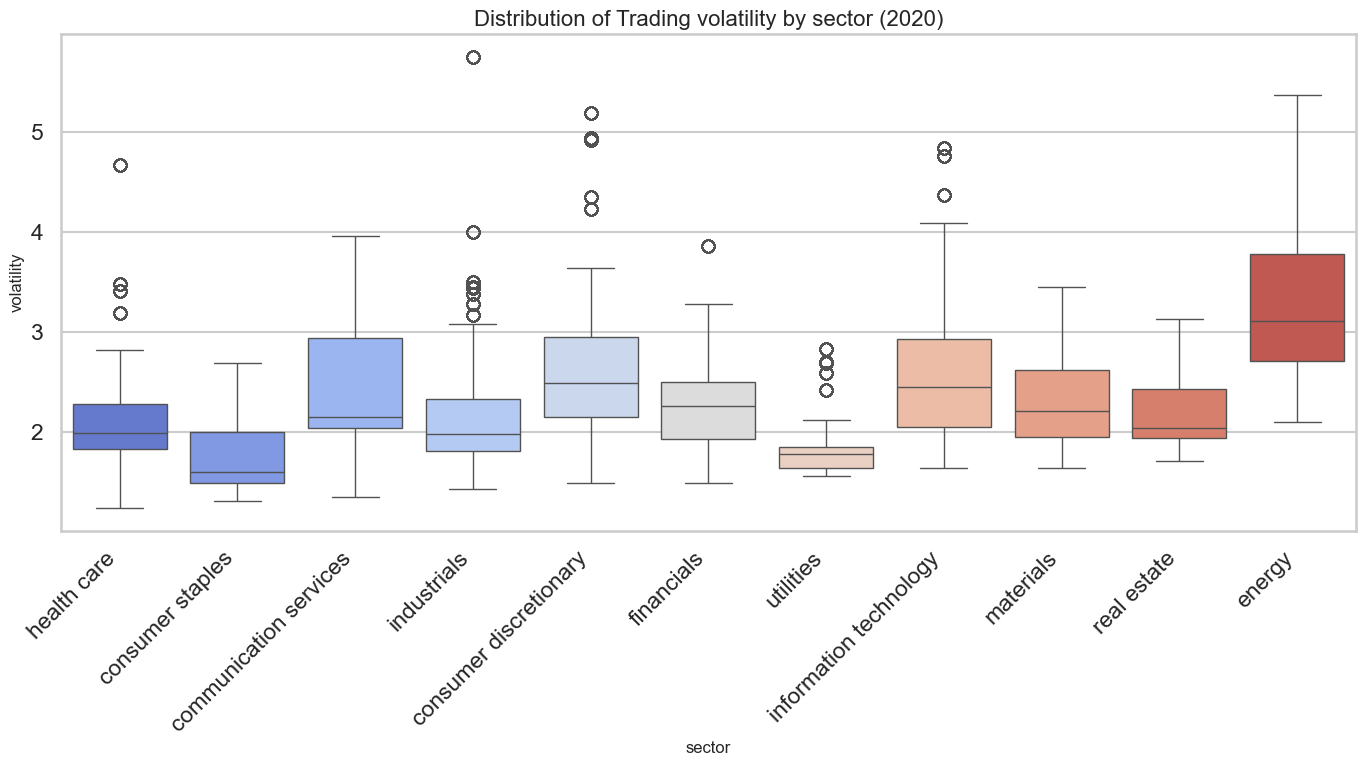

In [28]:
sorted_df = master_2020_all.sort_values(by='volatility', ascending=True)

# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.boxplot(data=sorted_df, x="sector", y="volatility", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading volatility by sector (2020)', fontsize=16)
plt.xlabel('sector', fontsize=12)
plt.ylabel('volatility', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

Text(0, 0.5, 'Count')

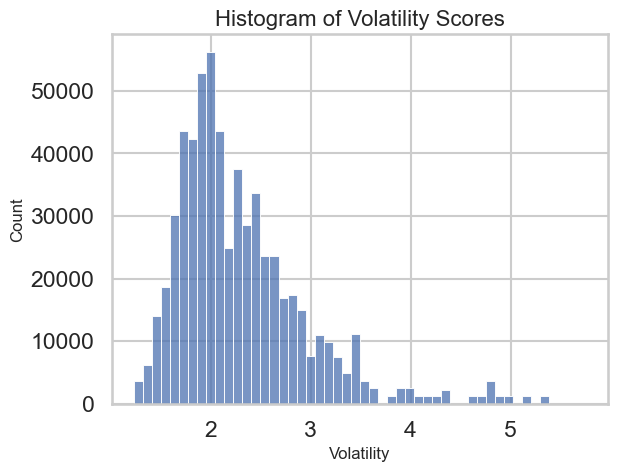

In [29]:
sns.histplot(master_2020_all["volatility"], bins=50)
plt.title("Histogram of Volatility Scores", fontsize=16)
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Count", fontsize=12)

In [30]:
inf_df = master_2020_all[["company", "sector", "volatility"]]
inf_df.drop_duplicates(inplace=True)
inf_df_group = inf_df.groupby("sector")["volatility"].agg(list).reset_index()
inf_df_group["average"] = inf_df_group["volatility"].apply(lambda x: sum(x) / len(x))
inf_df_group["std"] = inf_df_group["volatility"].apply(lambda x: np.std(x))

In [31]:
master_2020_all.groupby(by="sector")["volatility"].mean()

sector
communication services    2.337313
consumer discretionary    2.703183
consumer staples          1.774836
energy                    3.289703
financials                2.271417
health care               2.118041
industrials               2.160731
information technology    2.568747
materials                 2.330169
real estate               2.199536
utilities                 1.874696
Name: volatility, dtype: float64

In [32]:
# find p value
f_stat, p_value = stats.f_oneway(*inf_df_group["volatility"])
p_value

1.3875251289695803e-22

very low p-value
--> null hypothesis is rejected. There is a clear difference in volatility over different sectors of the S&P 500.

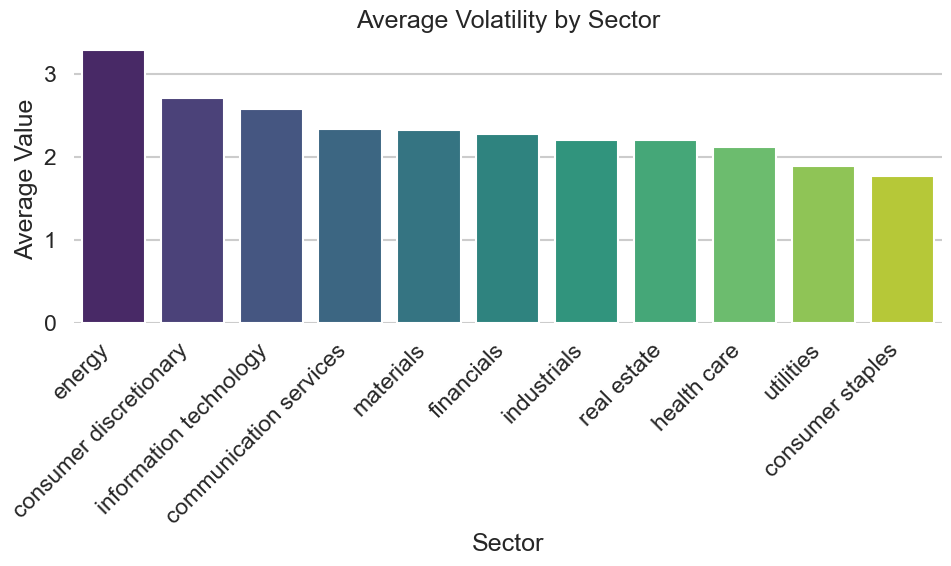

In [33]:
# plot volatility for all sectors

sorted_df = inf_df_group.sort_values(by='average', ascending=False)
plt.figure(figsize=(10, 6))

sns.barplot(x='sector', y='average', data=sorted_df, palette='viridis')
plt.xticks(rotation=45, ha='right')

plt.title('Average Volatility by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Value')


sns.despine(left=True, bottom=True)  # Remove top and right spines for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()

## Plots

### Boxplots

<Axes: xlabel='sector', ylabel='price_change'>

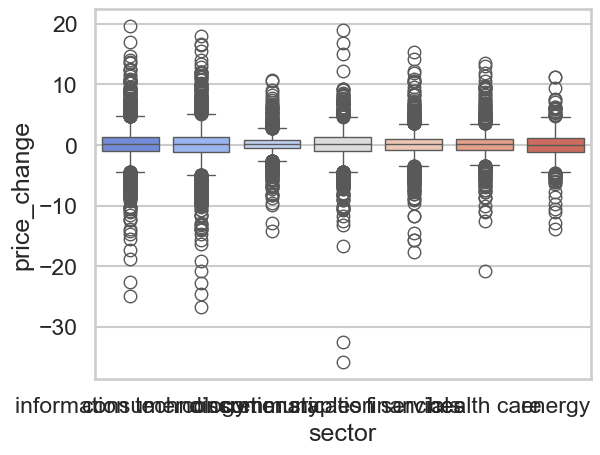

In [34]:
sns.boxplot(data=master_2020, x="sector", y="price_change", palette="coolwarm")


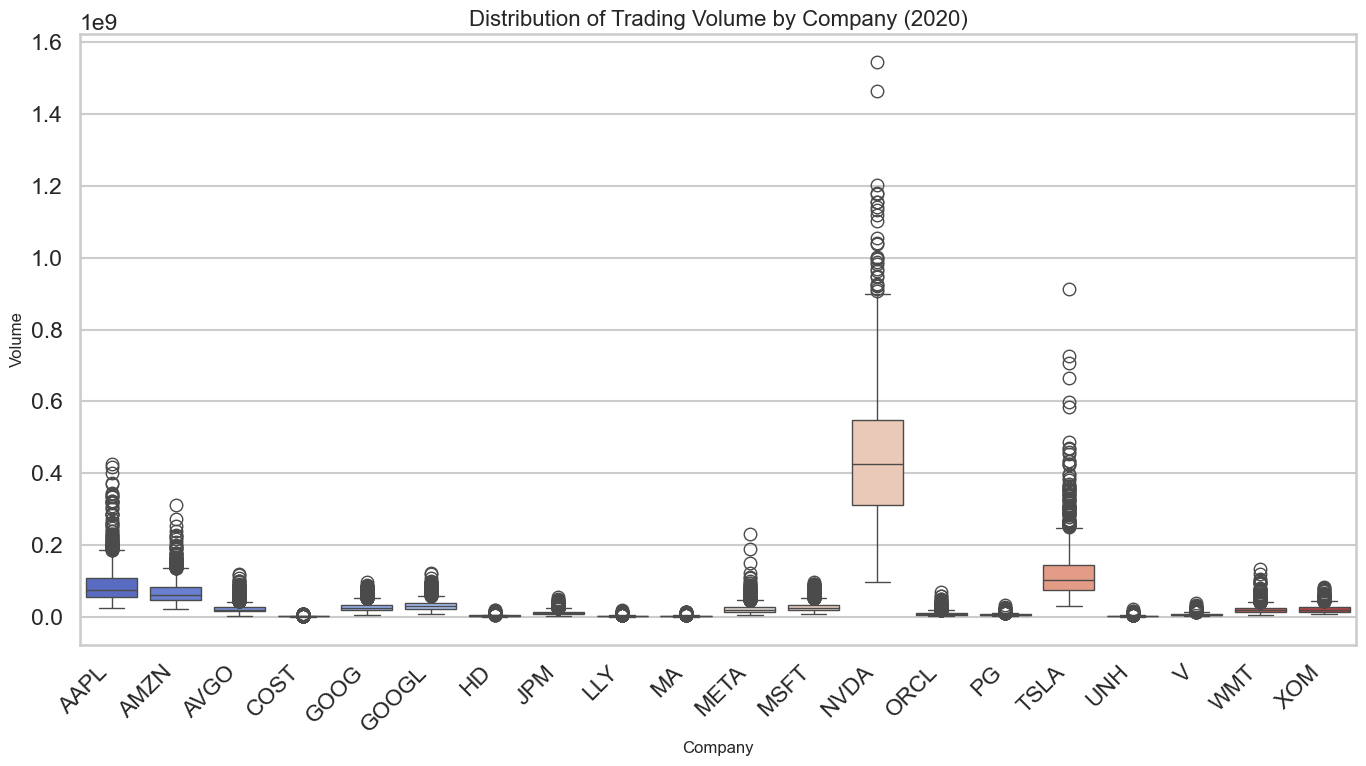

In [35]:
# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.boxplot(data=master_2020, x="company", y="volume", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

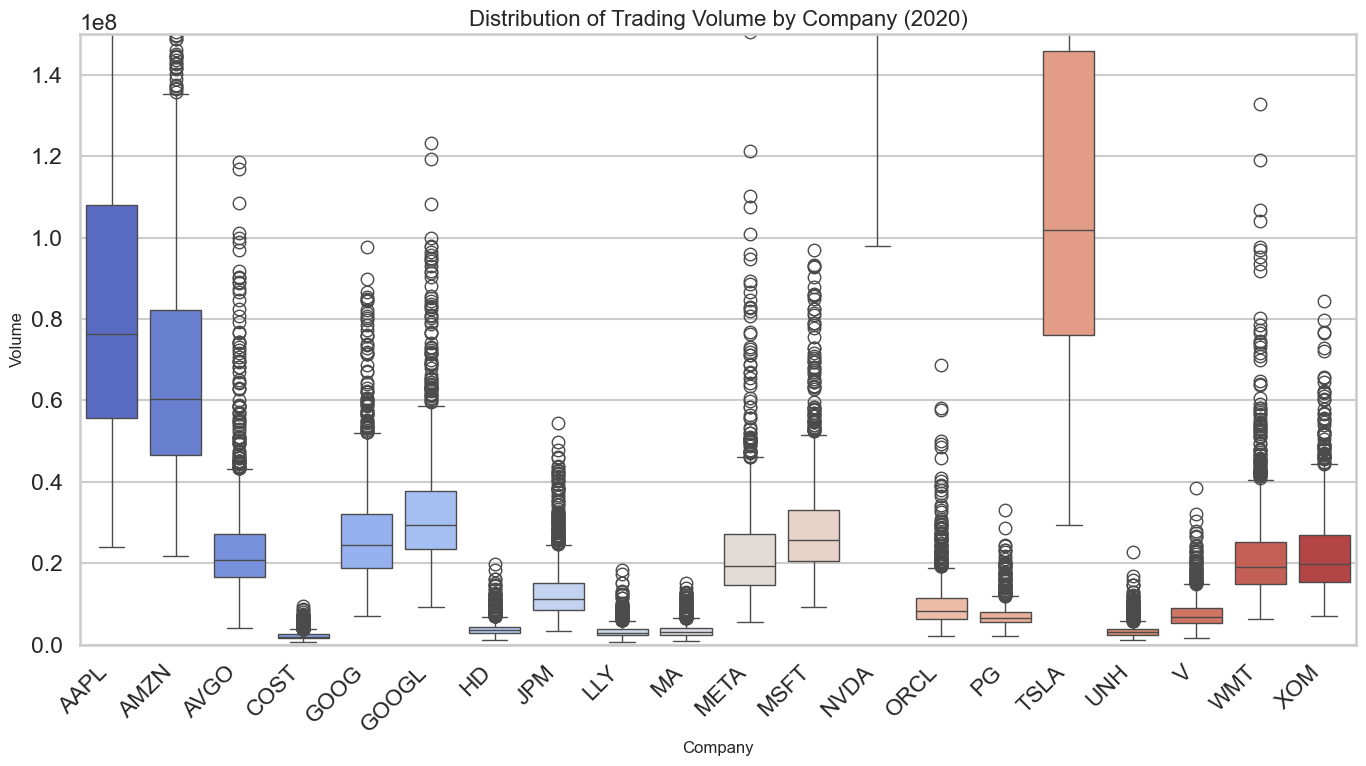

In [36]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="company", y="volume", palette="coolwarm")

plt.ylim(0, 150000000)  # Set your own limits here

plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

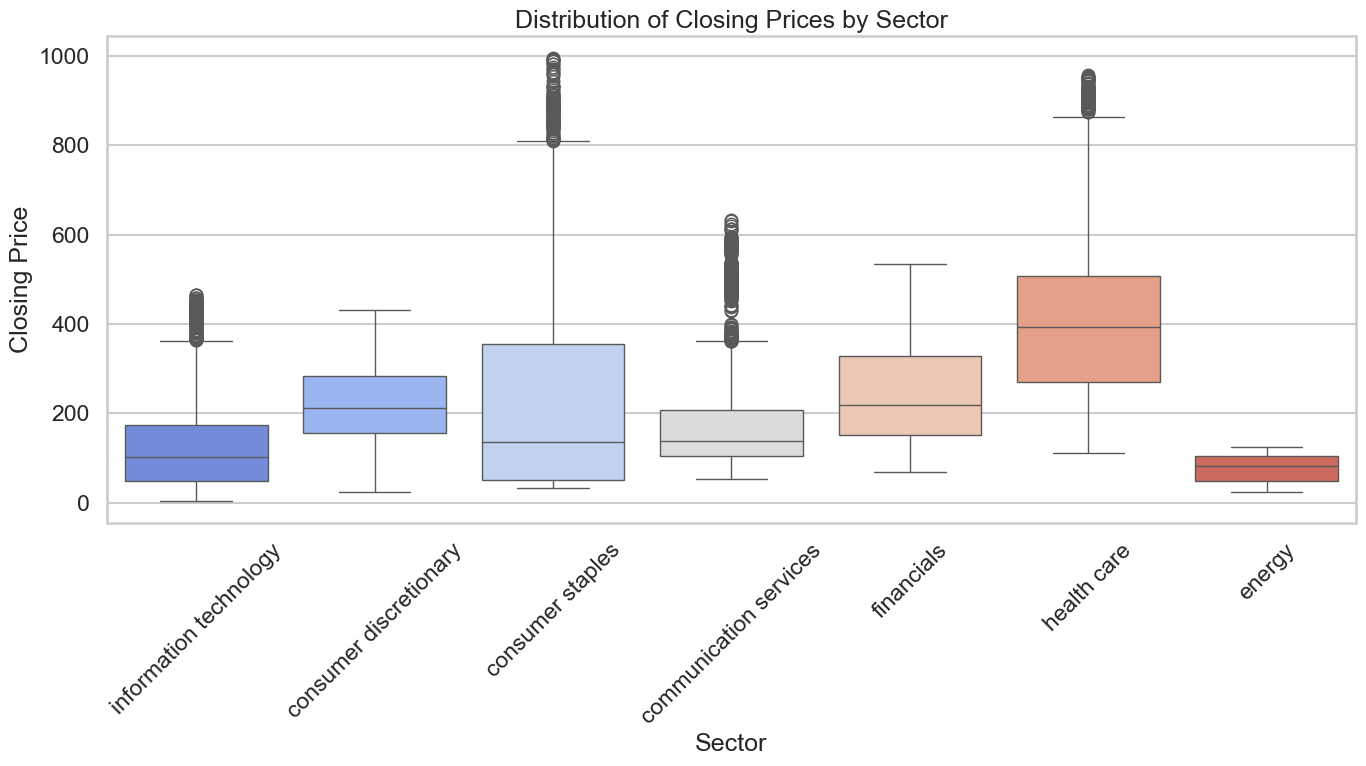

In [37]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="sector", y="close", palette="coolwarm")
plt.title("Distribution of Closing Prices by Sector")
plt.xlabel("Sector")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.tight_layout()

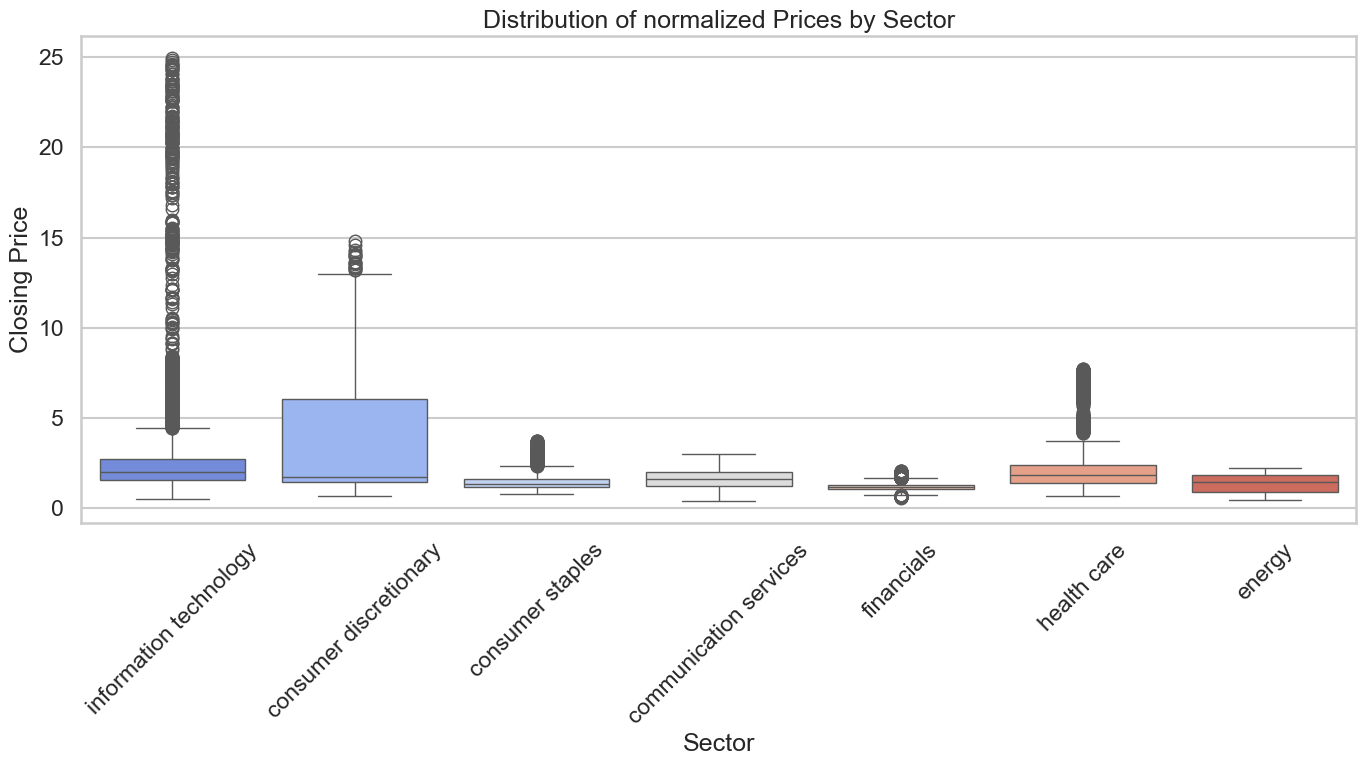

In [38]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="sector", y="norm_price_2020", palette="coolwarm")
plt.title("Distribution of normalized Prices by Sector")
plt.xlabel("Sector")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.tight_layout()

### Violin

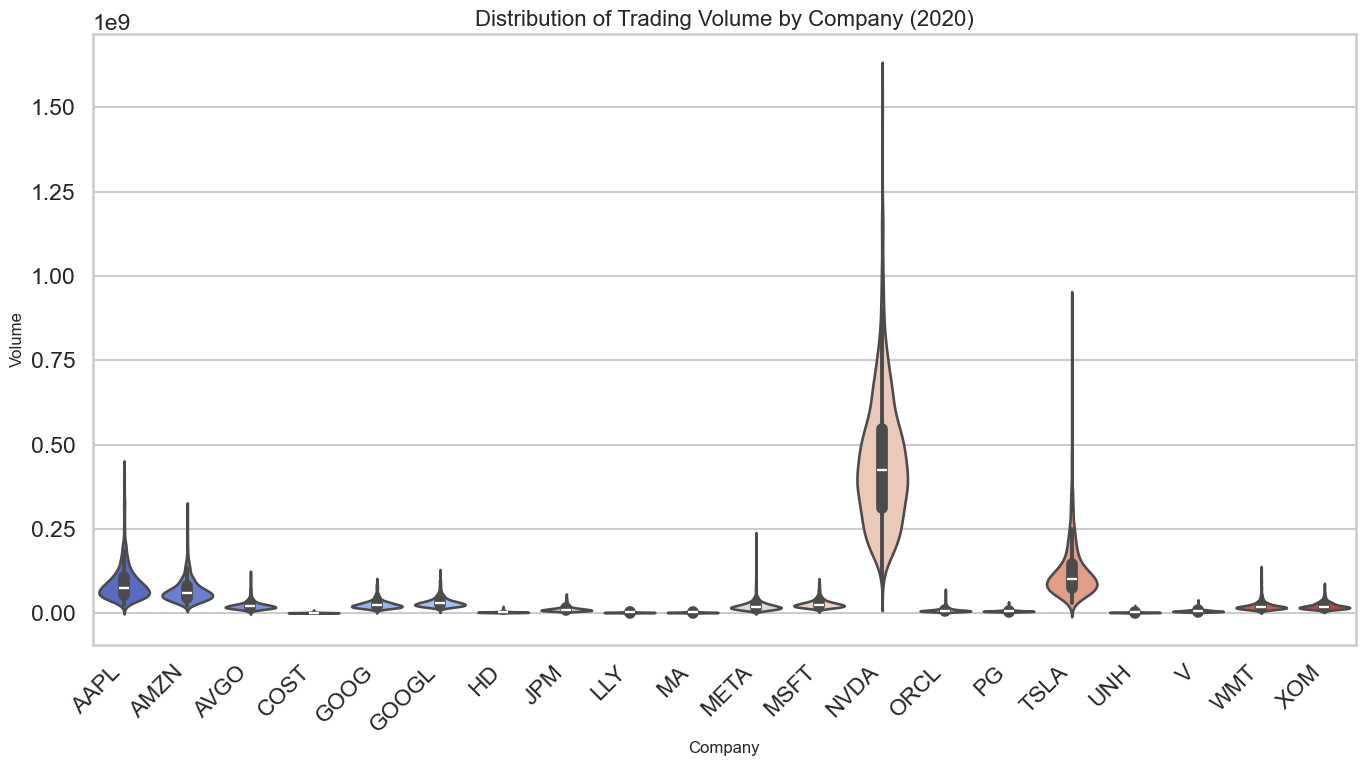

In [39]:
# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.violinplot(data=master_2020, x="company", y="volume", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

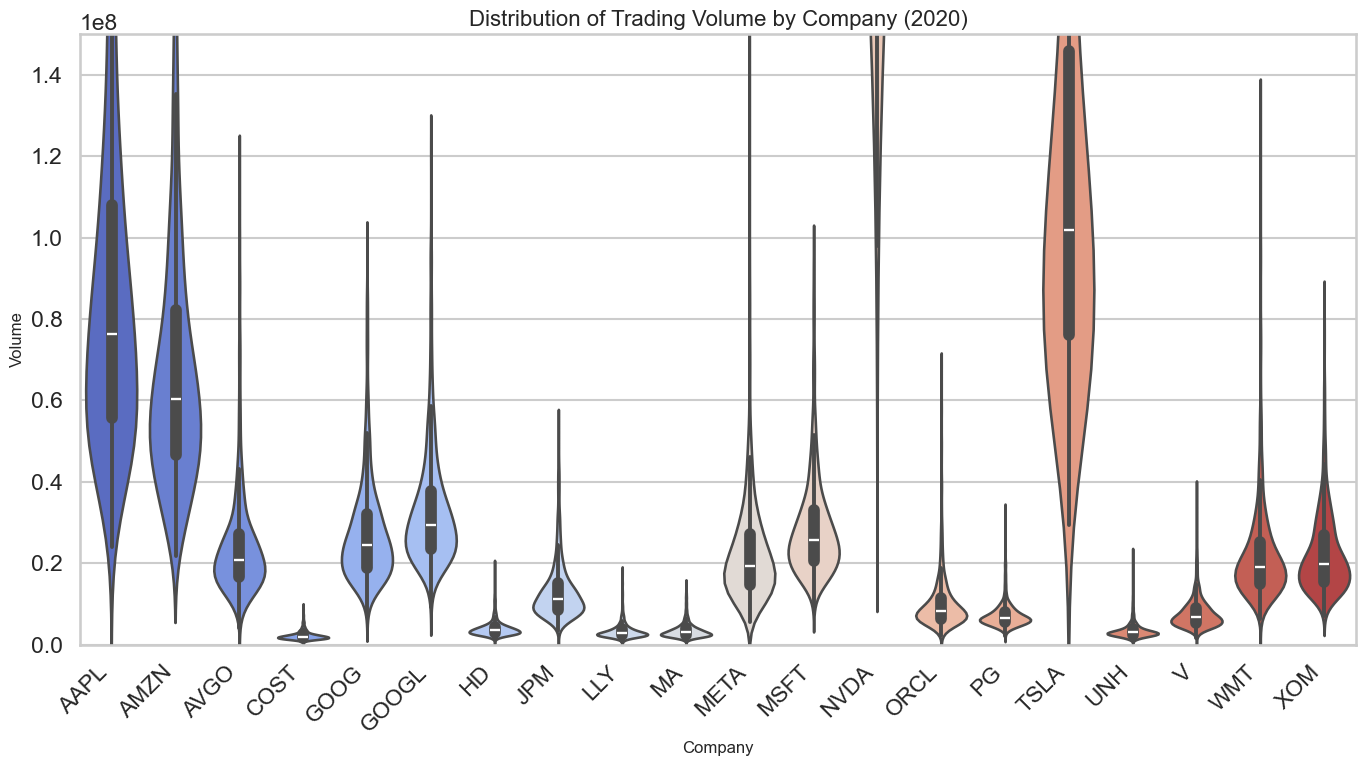

In [40]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=master_2020, x="company", y="volume", palette="coolwarm")

plt.ylim(0, 150000000)  # Set your own limits here

plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Scatterplots

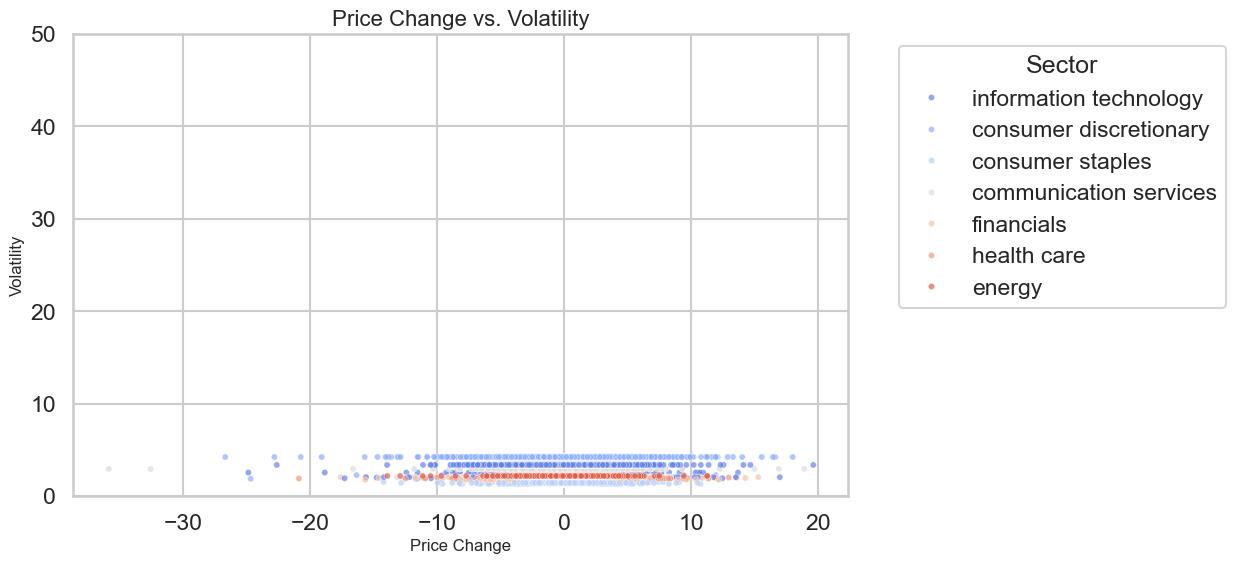

In [41]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    y="volatility", 
    x="price_change", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
    
)

# Add a title and axis labels
scatter_plot.set_title("Price Change vs. Volatility", fontsize=16)
scatter_plot.set_ylabel("Volatility", fontsize=12)
scatter_plot.set_xlabel("Price Change", fontsize=12)

plt.ylim(0, 50)  # Set your own limits here


# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

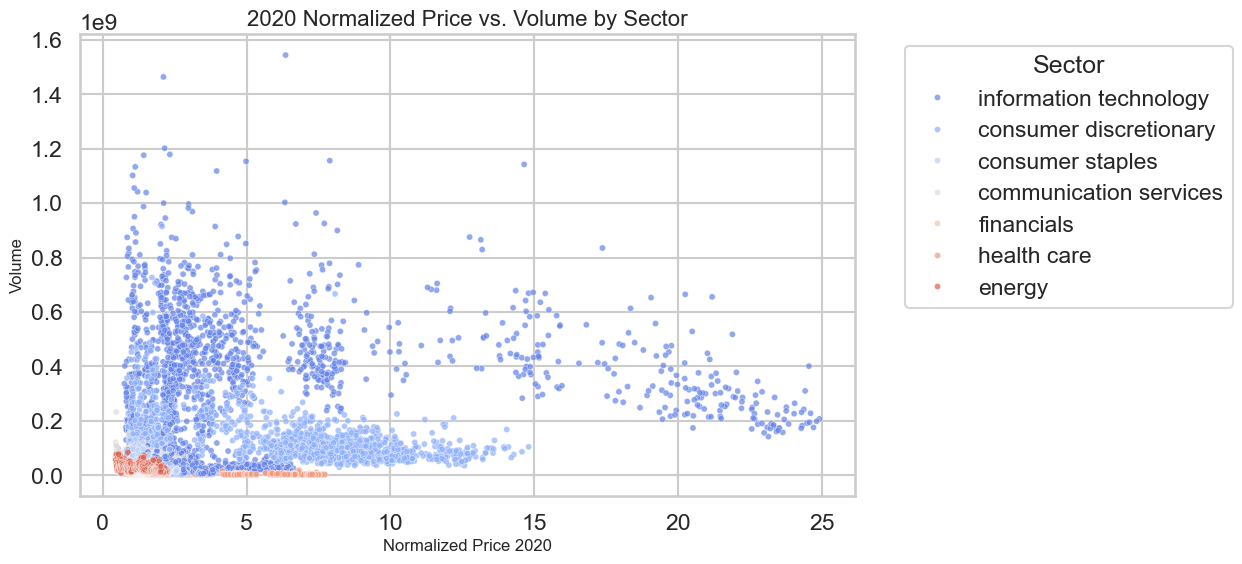

In [42]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    x="norm_price_2020", 
    y="volume", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
)

# Add a title and axis labels
scatter_plot.set_title("2020 Normalized Price vs. Volume by Sector", fontsize=16)
scatter_plot.set_xlabel("Normalized Price 2020", fontsize=12)
scatter_plot.set_ylabel("Volume", fontsize=12)

# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')


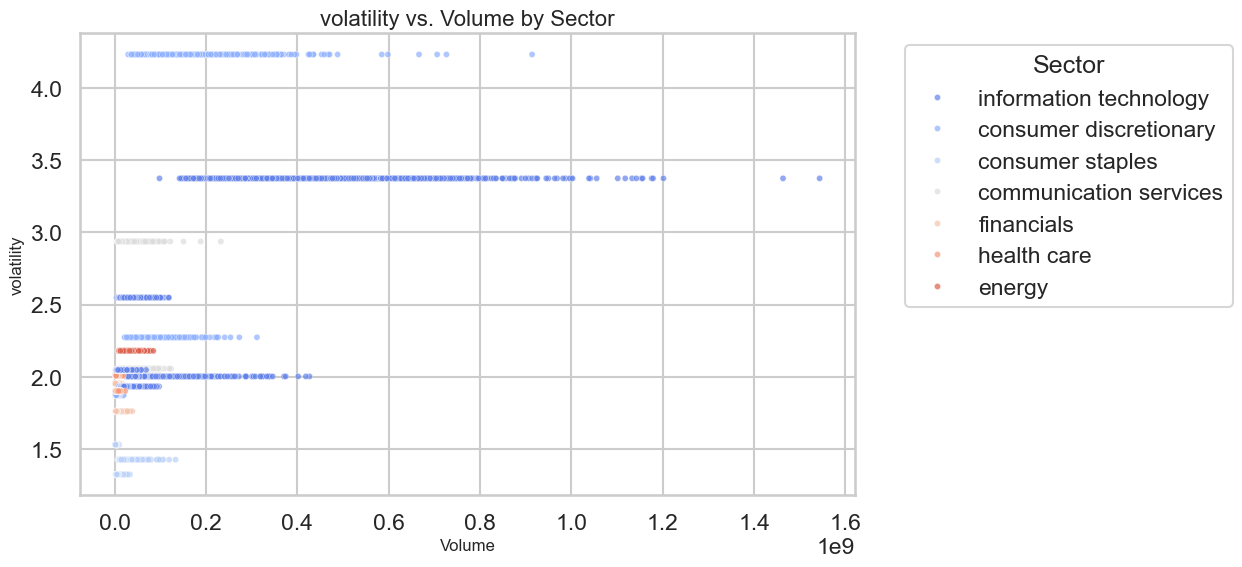

In [43]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    y="volatility", 
    x="volume", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
)

# Add a title and axis labels
scatter_plot.set_title("volatility vs. Volume by Sector", fontsize=16)
scatter_plot.set_xlabel("Volume", fontsize=12)
scatter_plot.set_ylabel("volatility", fontsize=12)

# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

In [44]:

# Create a scatter plot with Plotly
fig = px.scatter(
    master_2020,
    x="volume",
    y="norm_price_2020",
    color="sector",
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=40,  # Adjust this value to make points smaller
    opacity=0.7,
    labels={"sector": "Sector", "volume": "Volume", "norm_price_2020": "Normalized Price (2020)"}
)

# Update layout to mimic the aesthetics of the Matplotlib plot and adjust height
fig.update_layout(
    title="Normalized Prices vs Trading Volume by Sector",
    title_font_size=18,
    xaxis_title="Volume",
    yaxis_title="Normalized Price (2020)",
    legend_title_text="Sector",
    height=1000,  # Adjust this value to make the plot higher
    legend=dict(
        x=1.05,
        y=1,
        yanchor='top',
        xanchor='left',
        title_font_size=14
    )
)

### Barplots

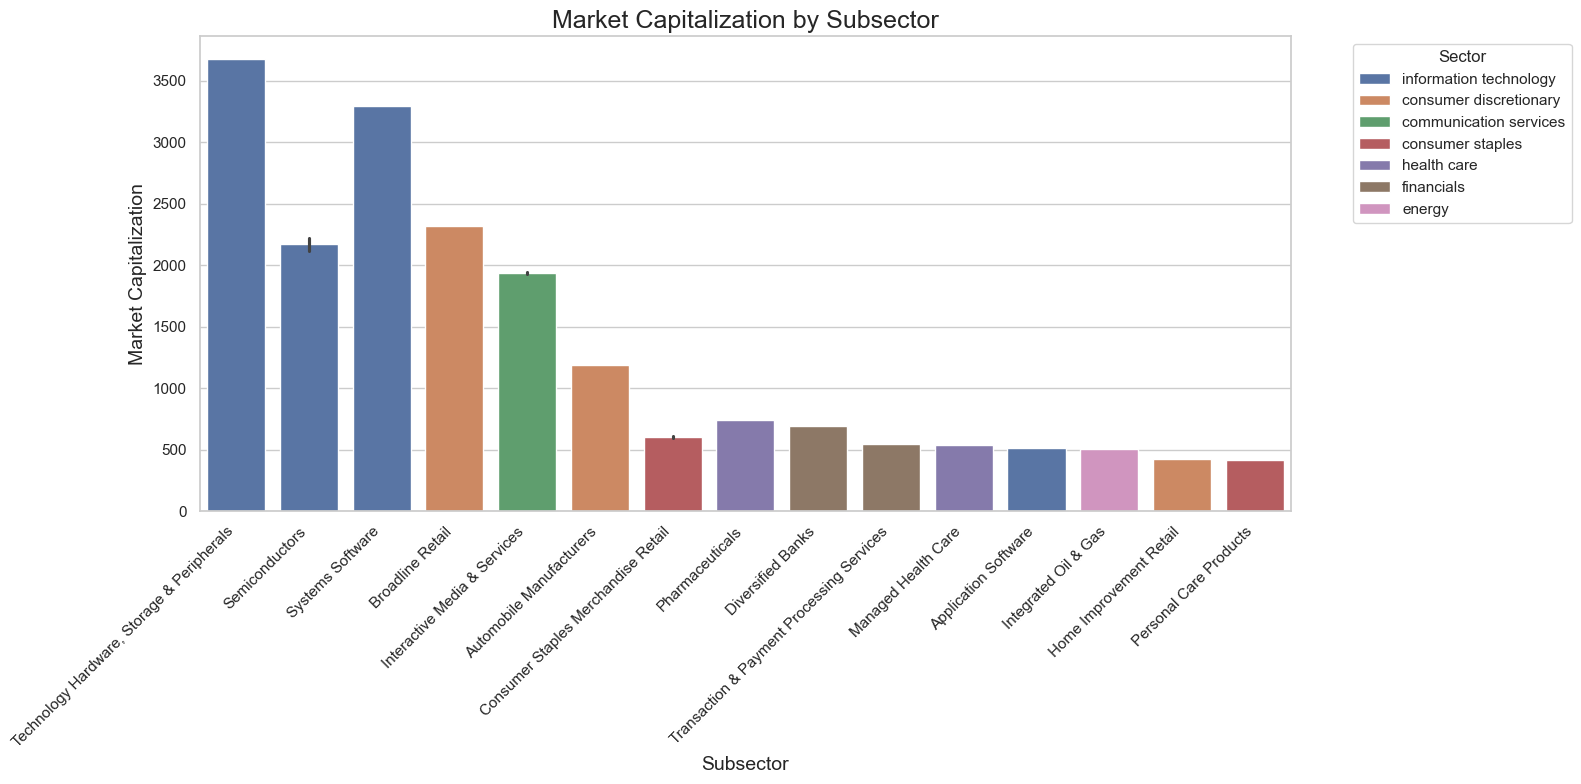

In [45]:
# Sort the data by market cap
sorted_data = master_2020.sort_values(by="marketcap", ascending=False)

# Set the style
sns.set(style="whitegrid")

# Create the barplot
plt.figure(figsize=(16, 8))
sns.barplot(x="subsector", y="marketcap", data=sorted_data, hue="sector")

# Enhance plot appearance
plt.title("Market Capitalization by Subsector", fontsize=18)
plt.xlabel("Subsector", fontsize=14)
plt.ylabel("Market Capitalization", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend to avoid overlap
plt.tight_layout()

### heatmap

In [46]:
num = master_2020.copy()
num = master_2020.select_dtypes("number")

In [47]:
# interactive correlation heat map

correlation_matrix = num.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
masked_correlation = correlation_matrix.mask(mask)

# Define custom color scale
color_scale = [
    [0.0, "rgb(5, 10, 172)"],    # Start color for negative
    [0.5, "rgb(255, 255, 255)"], # White for zero (middle)
    [1.0, "rgb(220, 10, 15)"]    # End color for positive
]

# Create the heatmap
fig = px.imshow(
    masked_correlation,
    color_continuous_scale=color_scale,
    zmin=-1,  # Minimum value of correlation
    zmax=1,   # Maximum value of correlation
    text_auto=".2f",
    aspect="auto",
    labels=dict(color="Correlation"),
    title="Correlation Matrix",
    height=600,
    width=1000
)

fig.update_traces(colorbar=dict(lenmode="fraction", len=0.8))
fig.update_layout(font=dict(size=12))
fig.show()